# Tutorial 2: FPR calibration curves 

This notebook demonstrates how to compute an exact calibration curve for black-box outlier detection systems, as in Figure 3 of the paper [1].
Precisely, we compute a simultaneous upper confidence bound for the false positive rate (FPR) of any one-class classifier, as a function of its output score.


## 1. Setup

We begin by importing some standard libraries that will be useful for this example.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import random
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from statsmodels.distributions.empirical_distribution import ECDF

random.seed(0)
np.random.seed(0)

/usr/lib/python3/dist-packages/tqdm/autonotebook/__init__.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  warn("Using `tqdm.autonotebook.tqdm` in notebook mode."


Now we import our custom library for this project, included in this repository.

In [2]:
import os
import sys
sys.path.append('../')

from cccpv.models import ToyModel
from cccpv.methods import CalibrationBound

## 2. Data generation

We will generate 50-dimensional data from the same toy model as in the paper (and as in Notebook 1).

In [3]:
random_state = 2021

p = 50        # Number of features
a = 3         # Signal amplitude

model = ToyModel(p, a, random_state=random_state)

n = 1000      # Number of observations
purity = 0.9  # Proportion of inliers

X, is_outlier = model.sample(n, purity=purity)

print("Number of inliers: {}.".format(np.sum(is_outlier==0)))
print("Number of outliers: {}.".format(np.sum(is_outlier==1)))

Number of inliers: 900.
Number of outliers: 100.


We will also generate a separate clean data set (no outliers) for training and calibration.

In [4]:
X_clean, _ = model.sample(n, purity=1)

## 3. Training an outlier detection black-box algorithm

First, we split the clean data set into training and calibration subsets. Then, we fit a one-class classifier on the training data.

In [5]:
# Split data into training and calibration subsets
X_train, X_calib = train_test_split(X_clean, test_size=0.5, random_state=random_state) 

# Choose a one-class classifier algorithm
method_oneclass = "IForest"

# Initialize the one-class classifier
contamination = 0.001
contamination = min(max(contamination,0.004),0.1)
if method_oneclass == "SVM":
    classifier = svm.OneClassSVM(nu=contamination, kernel="rbf", gamma=0.1)
if method_oneclass == "IForest":
    classifier = IsolationForest(random_state=random_state, contamination=contamination, behaviour="new")
if method_oneclass == "Neighbors":
    classifier = LocalOutlierFactor(novelty=True, contamination=contamination)
    
# Fit the black-box one-class classifier
classifier.fit(X_train)

/usr/lib/python3/dist-packages/sklearn/ensemble/_iforest.py:245: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


IsolationForest(behaviour='new', bootstrap=False, contamination=0.004,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=2021, verbose=0, warm_start=False)

## 4. Compute a calibration curve

Apply the one-class classifier to compute scores for the hold-out clean calibration data points.

In [6]:
# Compute scores on clean calibration data
scores_cal = classifier.score_samples(X_calib)

Then, compute the simultaneous upper confidence bound for the FPR, with $\delta=0.1$.

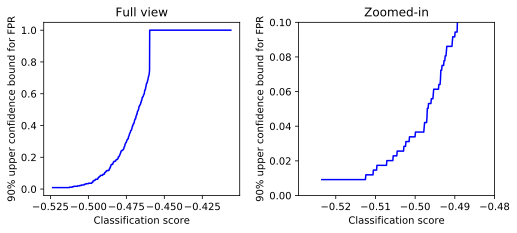

In [7]:
# Initialize upper FPR band
cband = CalibrationBound(scores_cal, delta=0.1)

# Evaluate the bound on a grid of values
x_grid = np.arange(np.min(scores_cal)-0.01, np.max(scores_cal)+0.01, 0.0001)
bound_y, _ = cband.evaluate(x_grid)

# Plot the bound
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

axs[0].plot(x_grid, bound_y, label="upper confidence bound", linestyle="-", color="blue")
axs[0].set_xlabel("Classification score")
axs[0].set_ylabel("90% upper confidence bound for FPR")
axs[0].title.set_text('Full view')

axs[1].plot(x_grid, bound_y, label="upper confidence bound", linestyle="-", color="blue")
axs[1].set_xlabel("Classification score")
axs[1].set_ylabel("90% upper confidence bound for FPR")
axs[1].set_xlim([None,-0.48])
axs[1].set_ylim([0,0.1])
axs[1].title.set_text('Zoomed-in')

plt.show()

## 5. Validate on test data

Let's see how well this does on test data.

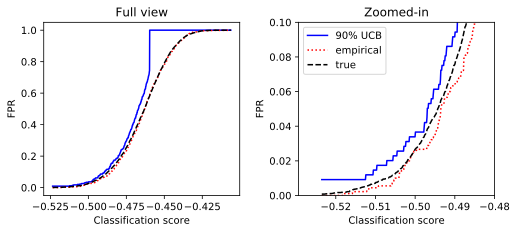

In [8]:
## Compute empirical FPR for test data
X_in = X[is_outlier==0]
scores_test = np.sort(classifier.score_samples(X_in))

# Evaluate empirical CDF on test scores
ecdf = ECDF(scores_test)
empirical_fpr = ecdf(x_grid)

# Evaluate the bound on this grid of values
bound_y, _ = cband.evaluate(x_grid)

# Compute the true FPR curve using Monte Carlo
X_mc, _ = model.sample(10000, purity=1)
scores_mc = np.sort(classifier.score_samples(X_mc))
ecdf = ECDF(scores_mc)
true_fpr = ecdf(x_grid)

# Compare the bound to the empirical FPR
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

axs[0].plot(x_grid, bound_y, label="90% UCB", linestyle="-", color="blue")
axs[0].plot(x_grid, empirical_fpr, label="empirical", linestyle=":", color="red")
axs[0].plot(x_grid, true_fpr, label="true", linestyle="--", color="black")
axs[0].set_xlabel("Classification score")
axs[0].set_ylabel("FPR")
axs[0].title.set_text('Full view')

axs[1].plot(x_grid, bound_y, label="90% UCB", linestyle="-", color="blue")
axs[1].plot(x_grid, empirical_fpr, label="empirical", linestyle=":", color="red")
axs[1].plot(x_grid, true_fpr, label="true", linestyle="--", color="black")
axs[1].set_xlabel("Classification score")
axs[1].set_ylabel("FPR")
axs[1].set_xlim([None,-0.48])
axs[1].set_ylim([0,0.1])
axs[1].title.set_text('Zoomed-in')

plt.legend()
plt.show()

## References

[1] Stephen Bates, Emmanuel Candes, Lihua Lei, Yaniv Romano, and Matteo Sesia. "Multiple Outlier Testing with Conformal p-values". arXiv preprint (2021).